#### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import time

In [2]:
from itertools import product
# open the file and read
#file = open("small_uniprot.txt", "r")
file = open("uniprot-reviewed-lim_sequences.txt", "r")

# skip the first line
file.readline()
sequences = file.read().rstrip()
letters = sorted(set(sequences.replace('\n','')))

# k-mer, n_gram size, k
n_gram = 3
# refer to window size w
context_size = 25
# negative sampling size q
neg_sample = 5
# get all permutations of letters
vocabs = list(map(lambda x: ''.join(x), list(product(letters, repeat=n_gram))))
# give each vocab a index
vocab_to_idx = {vocab: index+1 for index, (vocab) in enumerate(vocabs)}

In [3]:
from torch.utils.data import Dataset
# numpy searchsorted
class SEQPAIR_Dataset(Dataset):
    def __init__(self):
        super(SEQPAIR_Dataset, self).__init__()
        
        self.word_to_idx = dict()
        self.idx_to_word = dict()
        self.seq_to_ngrams = []
        self.word_to_prob = dict()
        self.CPD = []
        
        self.generate_ngrams(0)
        self.generate_ngrams(1)
        self.generate_ngrams(2)
        print(len(self.word_to_idx.keys()))
        
        for word in sorted(self.word_to_prob.keys()):
            self.CPD.append(self.word_to_prob[word] ** 0.75)
        
        self.CPD = np.array(self.CPD) / np.sum(self.CPD)
        self.CPD = np.cumsum(self.CPD)
    
    def generate_ngrams(self, offset=0):
        
        for sequence in sequences.split('\n'):
            n_grams = []
            begin = offset
            end = begin + n_gram
            while(end <= len(sequence)):
                word = sequence[begin:end]
                n_grams.append(vocab_to_idx[word])
                self.word_to_idx[word] = vocab_to_idx[word]
                self.idx_to_word[vocab_to_idx[word]] = word
                if word not in self.word_to_prob:
                    self.word_to_prob[word] = 1
                else:
                    self.word_to_prob[word] += 1
                begin += n_gram
                end += n_gram
            self.seq_to_ngrams.append(n_grams)
    
    def __len__(self):
        '''return len of dataset'''
        return len(self.seq_to_ngrams)
    
    def __getitem__(self, idx):
        
        n_grams = self.seq_to_ngrams[idx]
        size = len(n_grams)
        #space = size * (context_size-1) * (neg_sample+1)
        target_words = np.zeros((size,1)).astype(np.int_)
        context_words = np.zeros((size, context_size)).astype(np.int_)
        neg_words = np.zeros((size, context_size*neg_sample)).astype(np.int_)
        incre = (context_size-1) * (neg_sample+1)
        begin = 0
        end = begin + incre
        for i in range(0, size):
            
            target_words[i,0] = n_grams[i]
            leftbound = max(i-int(context_size/2), 0)
            left_size = i - leftbound
            rightbound = min(i+int(context_size/2), size)
            right_size = rightbound - i
            context_words[i, 0:left_size] = n_grams[leftbound:i]
            context_words[i, left_size:left_size+right_size] = n_grams[i:rightbound]
            prob = np.random.rand(context_size*neg_sample)
            pos = np.searchsorted(self.CPD, prob)
            neg_words[i,:] = pos.astype(np.int_)

        return target_words, context_words, neg_words

In [4]:
class ProteinEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        
        super(ProteinEmbeddingModel, self).__init__()
        
        # define target embedding layer
        self.target = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0, sparse=True)
        
        # define context embedding layer
        self.context = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0, sparse=True)
        
    def forward(self, target_words, context_words, neg_words):
        #print('enter')
        t = target_words[0]
        # get the target representation
        t = self.target(t)
        #print(t)
        
        c = context_words[0]
        # get the context representation
        c = self.context(c)
        c = torch.transpose(c, 1, 2)
        #print(c)
        
        n = neg_words[0]
        #print(n)
        n = self.context(n)
        n = torch.transpose(n, 1, 2)
        
        # calculate the dot product
        #x = torch.sum(t * c, 1)
        positive = torch.matmul(t, c).reshape(-1)
        negative = torch.matmul(t, n).reshape(-1)
        
        return torch.cat((positive, negative), 0), torch.cat((torch.ones(len(positive)), torch.zeros(len(negative))), 0)

#### Set Up Loading and Training

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")
batch_size = 5000
learning_rate = 0.05
embedding_dim = 100
model = ProteinEmbeddingModel(len(vocab_to_idx)+1, embedding_dim).to(device)
optimizer = optim.SparseAdam(model.parameters(), lr=learning_rate)
data = SEQPAIR_Dataset()

checkpoint = torch.load('checkpoint2.pth')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model = model.to(device)
model.eval()

using device: cuda:0
10150


ProteinEmbeddingModel(
  (target): Embedding(15626, 100, padding_idx=0, sparse=True)
  (context): Embedding(15626, 100, padding_idx=0, sparse=True)
)

#### Write to File and T-SNE

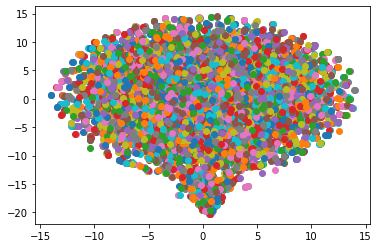

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# print(vocab_to_idx['AAA'])
# print(model.target(torch.tensor(1).to(device)))
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random')
#X_embedded.fit_transform(([[1,2,3],[4,5,6]]))
embeds = []
file_o = open('output.txt', 'w')
file_o.write(str(len(data.CPD)) + ' ' + str(embedding_dim) + '\n')
for word in sorted(data.word_to_idx.keys()):
    index = data.word_to_idx[word]
    embed = model.target(torch.tensor(index).to(device)).tolist()
    embeds.append(embed)
    embed = ' '.join(list(map(lambda x: str(x), embed)))
    file_o.write(word + ' ' + embed + '\n')

X_transform = X_embedded.fit_transform(np.array(embeds))
for i in range(len(embeds)):
    plt.scatter(X_transform[i, 0], X_transform[i, 1])
plt.show()